In [1]:
import torch    
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
        

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(batch_norm=False):
    layers = []
    in_channels = 3
    cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    
    if batch_norm:
        cfg.insert(6, 'BN')
        
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            if v == 'BN':
                layers.pop()
                layers += [nn.BatchNorm2d(in_channels), nn.ReLU(inplace=True)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
    return nn.Sequential(*layers)

In [3]:
vgg = VGG(make_layers(batch_norm=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001)

useGPU = False
device = torch.device('cuda' if torch.cuda.is_available() and useGPU else 'cpu')

vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=T

In [7]:
loss_values = []
ics_values = []
cos = torch.nn.CosineSimilarity(dim=0)
vgg.train()
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (data, target) in enumerate(trainloader, 0):
        if i >= 100:
            break
        inputs, labels = data.to(device), target.to(device)
    
        # forward + backward + optimize
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # si aggiornano i parametri del net di partenza

        # print statistics
        running_loss += loss.item()
        steps = 10
        if i % steps == (steps - 1):    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, (i + 1) * 128, running_loss / steps))
            loss_values.append(running_loss/steps)
            running_loss = 0.0

print('Finished Training')

[1,  1280] loss: 2.502
[1,  2560] loss: 2.514
[1,  3840] loss: 2.335
[1,  5120] loss: 2.280
[1,  6400] loss: 2.389
[1,  7680] loss: 2.412
[1,  8960] loss: 2.372
[1, 10240] loss: 2.296
[1, 11520] loss: 2.301
[1, 12800] loss: 2.332
Finished Training


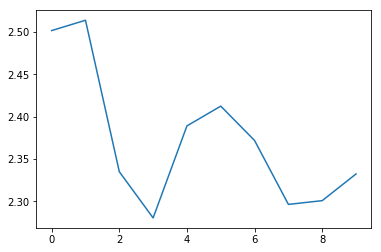

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.savefig('loss_vgg.png', dpi=300)